

# Autoencoders

Autoencoders are a special kind of neural network used to perform dimensionality reduction. We can think of autoencoders as being composed of two networks, an **encoder** $e$ and a **decoder** $d$.

The encoder learns a non-linear transformation $e:X \to Z$ that projects the data from the original high-dimensional input space $X$ to a lower-dimensional **latent space** $Z$. We call $z = e(x)$ a **latent vector**. A latent vector is a low-dimensional representation of a data point that contains information about $x$. The transformation $e$ should have certain properties, like similar values of $x$ should have similar latent vectors (and dissimilar values of $x$ should have dissimilar latent vectors).

A decoder learns a non-linear transformation $d: Z \to X$ that projects the latent vectors back into the original high-dimensional input space $X$. This transformation should take the latent vector $z = e(x)$ and reconstruct the original input data $\hat{x} = d(z) = d(e(x))$.

An autoencoder is just the composition of the encoder and the decoder $f(x) = d(e(x))$. The autoencoder is trained to minimize the difference between the input $x$ and the reconstruction $\hat{x}$ using a kind of **reconstruction loss**. Because the autoencoder is trained as a whole (we say it's trained "end-to-end"), we simultaneosly optimize the encoder and the decoder.

Below is an implementation of an autoencoder written in PyTorch. We apply it to the MNIST dataset.

In [16]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [18]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)
    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        return self.linear2(x)

In [19]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 784)
        
    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))

In [20]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)
    
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

Next, we will write some code to train the autoencoder on the MNIST dataset.

In [21]:
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in range(epochs):
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum()
            loss.backward()
            opt.step()
    return autoencoder

In [22]:
latent_dims = 2
autoencoder = Autoencoder(latent_dims).to(device) # GPU

data = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data', 
               transform=torchvision.transforms.ToTensor(), 
               download=True),
        batch_size=128,
        shuffle=True)

autoencoder = train(autoencoder, data)


Sample the latent space to produce output. If the latent space is 2-dimensional, we can sample latent vectors $z$ from the latent space over a uniform grid and plot the decoded latent vectors on a grid.

In [23]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

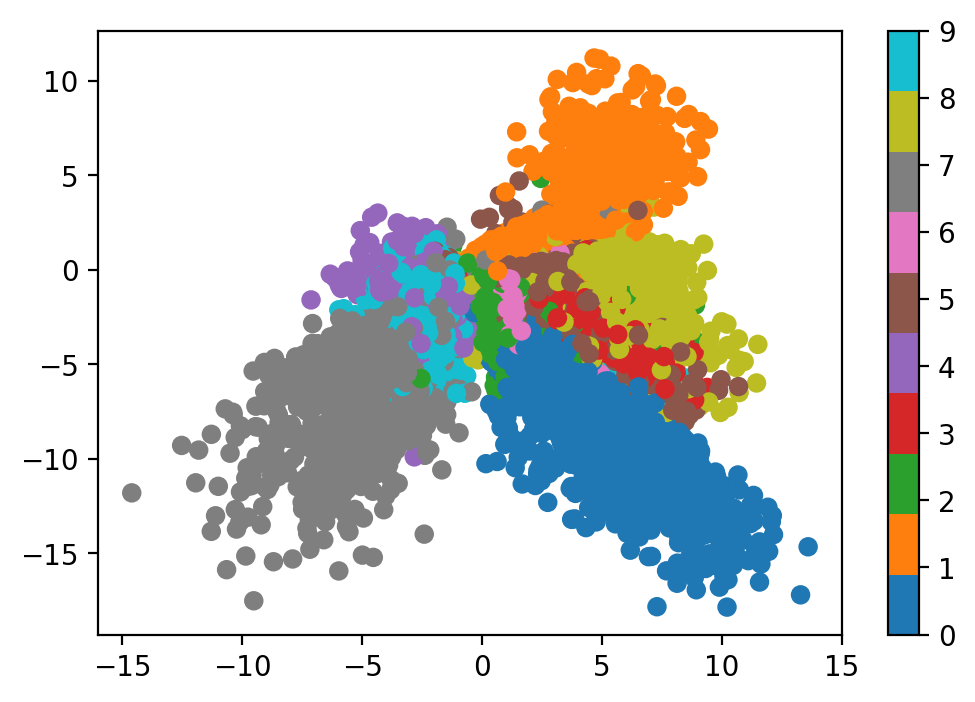

In [24]:
plot_latent(autoencoder, data)

The resulting latent vectors cluster similar digits together. We can also sample uniformly from the latent space and see how the decoder reconstructs inputs from arbitrary latent vectors.

In [25]:
def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

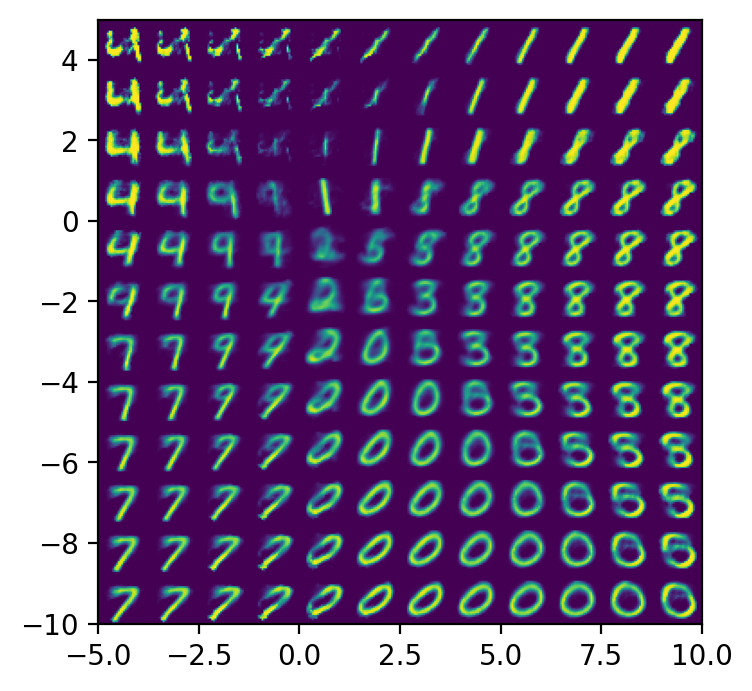

In [26]:
plot_reconstructed(autoencoder)

We can see that the reconstructed latent vectors look like digits, and the kind of digit corresponds to the location of the latent vector in the latent space. 

# Variational Autoencoders


In traditional autoencoders, inputs are mapped deterministically to a latent vector $z = e(x)$. In variational autoencoders, inputs are mapped to a probability distribution over latent vectors, and a latent vector is then sampled from that distribution. The decoder becomes more robust at decoding latent vectors as a result. 

Specifically, instead of mapping the input $x$ to a latent vector $z = e(x)$, we map it instead to a mean vector $\mu(x)$ and a vector of standard deviations $\sigma(x)$. These parametrize a diagonal Gaussian distribution $\mathcal{N}(\mu, \sigma)$, from which we then sample a latent vector $z \sim \mathcal{N}(\mu, \sigma)$.


However, this does not completely solve the problem. There may still be gaps in the latent space because the outputted means may be significantly different and the standard deviations may be small. To reduce that, we add an **auxillary loss** that penalizes the distribution $p(z \mid x)$ for being too far from the standard normal distribution $\mathcal{N}(0, 1)$. This penalty term is the KL divergence between $p(z \mid x)$ and $\mathcal{N}(0, 1)$, which is given by
$$
\mathbb{KL}\left( \mathcal{N}(\mu, \sigma) \parallel \mathcal{N}(0, 1) \right) = \sum_{x \in X} \left( \sigma^2 + \mu^2 - \log \sigma - \frac{1}{2} \right)
$$

To implement this, we do not need to change the `Decoder` class. We only need to change the `Encoder` class to produce $\mu(x)$ and $\sigma(x)$, and then use these to sample a latent vector. We also use this class to keep track of the KL divergence loss term.

In [27]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)
        
        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0
    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

The autoencoder class changes a single line of code, swappig out an `Encoder` for a `VariationalEncoder`. 

In [28]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)
    
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In order to train the variational autoencoder, we only need to add the auxillary loss in our training algorithm.

The following code is essentially copy-and-pasted from above, with a single term added added to the loss (`autoencoder.encoder.kl`).

In [29]:
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in range(epochs):
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl
            loss.backward()
            opt.step()
    return autoencoder

In [30]:
vae = VariationalAutoencoder(latent_dims).to(device) # GPU
vae = train(vae, data)

AssertionError: Torch not compiled with CUDA enabled

Let's plot the latent vector representations of a few batches of data.

In [ ]:
plot_latent(vae, data)

We can see that, compared to the traditional autoencoder, the range of values for latent vectors is much smaller, and more centralized. The distribution overall of $p(z \mid x)$ appears to be much closer to a Gaussian distribution.

Let's also look at the reconstructed digits from the latent space:

In [ ]:
plot_reconstructed(vae, r0=(-3, 3), r1=(-3, 3))

# Conclusions

Variational autoencoders produce a latent space $Z$ that is more compact and smooth than that learned by traditional autoencoders. This lets us randomly sample points $z \sim Z$ and produce corresponding reconstructions $\hat{x} = d(z)$ that form realistic digits, unlike traditional autoencoders.

This post is inspired by these articles:
- [Intuitively Understanding Variational Autoencoders](https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf)
- [Understanding Variational Autoencoders (VAEs)](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73)